## 1. Introducción
Esta es una red neuronal convolucional secuencial de 5 capas para entrenar el reconocimiento de dígitos en el dataset recolectado de este concurso. Se ha seleccionado construir la red con la API keras (Tensorflow backend), la cual es muy intuitiva. Primero, se van a preparar los datos (imágenes de dígitos escritos a mano) luego se enfocará en el modelado y evaluación de la CNN.

In [1]:
#!pip install seaborn 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

## 2. Preparación de Datos

### 2.1 Carga de datos

In [3]:
X_train = []
import os
import cv2
df = pd.read_csv('../data/label_digitos.csv', sep = ',', encoding='utf-8')
for i in df.name:
    img = cv2.imread(f'../data/images_digitos/{i}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (28,28))
    X_train.append(img)
X_train = np.array(X_train)
Y_train = df.label
X_train.shape, Y_train.shape

((1834, 28, 28), (1834,))

### 2.3 Normalización

Se realizará una normalización de escala de grises para reducir el efecto de las diferencias de iluminación.

Además la red neuronal convolucional (CNN) convergerá más rápido en datos entre [0..1]  que en [0..255].

In [4]:
# Se cambia la forma de la imagen en 3 dimensiones (alto = 28px, ancho=28px, canal =1)
X_train = X_train.reshape(-1,28,28,1)
X_train = X_train/255.0

In [5]:
X_train.shape

(1834, 28, 28, 1)

Las imagenes de entrenamiento y prueba (28px x 28px) han sido cargadas en pandas.Dataframe como vectores de 1D de 784 valores. Se reformatean los datos a matrices 3D 28x28x1. 

Keras necesita una dimensión extra al final que corresponde a los canales. Como las imágenes MNIST son en la escala de grises, solo utilizan un canal. Para las imágenes RGB, hay 3 canales, las cuales deberían ser reformadas a 784 vectores a matrices 3D de 28x28x3.

### 2.5 Codificación de las etiquetas (target)

In [6]:
# Codificar las etiquetas a un vector (por ejemplo: 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 11)
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
Y_train.shape

(1834, 11)

Etiquetas son números de 10 dígitos desde 0 a 9. Necesitamos codificar estas etiquetas a un vector (ej : 2 -> [0,0,1,0,0,0,0,0,0,0]).

## 2.6 Separar los grupos de entrenamiento y validación

In [8]:
# Separar los grupos de entrenamiento y validación para el ajuste del modelo
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2, stratify = Y_train)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((1650, 28, 28, 1), (184, 28, 28, 1), (1650, 11), (184, 11))

Se decidió dividir el conjunto de entrenamiento en dos partes: una pequeña fracción (10%) será el conjunto de validación, el cual se utiliza para evaluar al modelo, y el resto (90%) es utilizado para entrenar el modelo.

Como tenemos 327 imagenes de entrenamiento con etiquetas desbalancedas, una división aleatoria del conjunto de entrenamiento causaría que algunas etiquetas sean sobrerepresentadas en al conjunto de validación. Se debe ser cuidadoso con los dataset no balanceados dado que una división simple aleatoria puede causar la evaluación incorrecta durante la validación.

Para evitar esto, se puede utilizar la opción "stratify = True" en la función de división de entrenamiento y prueba (solo para >= 0.17 sklearn ).

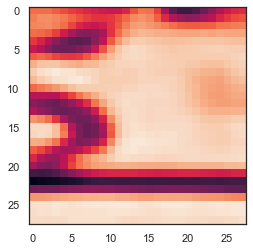

In [9]:
# Algunos ejemplos
g = plt.imshow(X_train[2][:,:,0])

## 3. CNN

### 3.1 Definir el modelo

Se utilizó Keras Sequencial API, donde se puede agregar una capa a la vez, comenzando desde la entrada.

La primera es la capa convolucional (Conv2D). Es como un conjunto de filtros que aprenden. Se seleccionó 32 filtros para los dos primeras capas conv2D y 64 filtros para las últimas dos. Cada filtro transforma parte de la imagen (definido por el tamaño del kernel) utilizando el filtro del kernel. La matriz del filtro del kernel es aplicada a toda la imange. Los filtros puede ser vistos como una transformación de la imagen. 

La CNN puede aislar características que son útiles de las imágenes transformadas (mapas de características). 

La segunda capa importante en la CNN es la capa de pooling (MaxPool2D). Esta capa simplemente actual como un filtro de downsampling (disminución de muestreo??). Se fija en los 2 píxeles vecinos y selecciona el de valor máximo. Estos son utilizados para reducir el costo computacional, y en algún punto reducir el overfitting (sobreajuste). Tendremos que seleccionar el tamaño de pooling  (ej. el tamaño del area pooled cada vez), mientras más grande es la dimensión del pooling, más importante es el downsampling. 

Combinando capas convolucionales y de pooling, las CNN son capaces de combinar características locales y aprender características más globale de la imagen.

Dropout es un método de regularización, donde una proporción de los nodos en la capa son ignorados de manera aleatoria (cambiando sus pesos a cero ) para cada muestra de entrenamiento. Esto elimina aleatoriamente una proporción de la red y fuerza a la red a aprender nuevas características en una forma distribuida. Esta técnica también mejora la generalización y reduce el overfitting (sobreajuste).

'relu' es un rectificador, función de activación max(0,x). La función rectificadora de activación es utilizada para agregar no linearidad a la red.

La capa Flatten es utilizada para convertir los mapas de la característica final en un simple vector 1D. Este paso de (flatten) alisamiento?? es necesario para que se puedan utilizar capas completamente conectadas después de algunas capas convolucionales/maxpool. Combina todas las caracteristicas encontradas de las capas convolucionales previas.

Al final se usan las características en dos capas (Dense) completemanete conectadas (fully-connected) el cual es solamente una un clasificador de neuronal artificial (ANN) . En la última capa (Dense(10,activation="softmax")) la red realiza/produce una distribución de probabilidad para cada clase. 

In [10]:
# Configurar el modelo CNN (Convolutional Neural Network)
# la arquitecture CNN es -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(11, activation = "softmax"))

## 3.2 Configurar el optimizador y annealer (templado??)

Una vez que las capas son agregadas al modelo, se necesita configurar la función de score (puntuación, calificación), una función de pérdida y un algoritmo de optimización.

Se define la función de pérdida para medir cuan mal le va al modelo con imágenes con etiquetas conocidas. Este es un ratio de error entre las etiquetas observadas y las predichas. Se usa una forma específica para clasificaciones categóricas (>2 clases) llamada "categorical_crossentropy" (entropía cruzadas categorica).

La función más importante es el optimizador. Esta función literalmente mejorará los parámetros (valores de filtros del kernel, pesos y desvíos (bias) de las neuronas ...) para minimizar la pérdida.

Se seleccionó RMSprop (con los valores por defecto), el cual es un optimizador muy efectivo. El cambio RMSProp ajusta el método Adagrad en una forma muy simple en un intento para reducir su ratio de aprendizaje (learning rate) agresivo y monotónicamente decreciente. Se podría haber utilizado el optimizador Gradiente Estocástico Descendiente (Stochastic Gradient Descent - sgd), pero es más lento que RMSProp.

La función de metricas "precisión" es utilizada para evaluar la "performance" (calidad) del modelo. Esta métrica es similar a la función de pérdida, con la excepción de que los resultados de la métrica de evaluación no son utilizados cuando se entrena el modelo (solo para evaluación).

In [11]:
# Definición del modelo
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [12]:
# Compilar el modelo
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Con el objetivo hacer que le optimizador converja más rápido y más cerca al minimo global de la función de pérdida, se ha utilizado un método de templado (annealing) del ratio de aprendizaje (LR).

El ratio de aprendizaje (LR) es un paso por el cual el optimizador recorre a través de un "loss landscape" (paisaje perdido). Mientras más grande el LR, más grande son los pasos y más rápido convergen. Sin embargo el muestreo es muy pobre con un gran LR y el optimizado probablemente caiga en un mínimo local.

Es mejor tener un ratio de aprendizaje decreciente para alcanzar efecientemente el mínimo global de la función de pérdida.

Para tomar ventaja del rápido tiempo de computación con un LR grande, se decreció (redujo) el LR dinámicamente cada X pasos (épocas) dependiendo si es necesario ( cuando la presición no mejora).

Con la función ReduceLROnPlateau de Keras.callbacks, se eligió reducir el LR por la mitad si la presición no mejora luego de 3 épocas.

In [13]:
# Configurar el templador (annealer) del ratio de aprendizaje (LR)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',#'val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
epochs = 150 # Cambiar las épocas a 30 para obtener una precisión de 0.9967
batch_size = 86

## 3.3 Aumento de datos (Data Augmentation)

Para evitar un problema de sobreajuste (overfitting), se necesita expandir artificialmente el conjunto de datos de digitos escritos a mano. Se puede hacer el conjunto de datos existente aún más grande. La idea es modificar los datos de entrenamiento con pequeñas transformaciones para reproducir las variaciones que ocurren cuando alguien escribe un dígito.

Por ejemplo, el número no está centrado. La escala no es la misma (algunos escriben número grandes o chicos), la imagen está rotada...

Métodos que alteran los datos de entrenamiento en formas que cambian la matrix de representación mientras mantienen la misma etiqueta son conocidos como técnicas de aumento de datos (data augmentation). Algunos aumentos de datos conocidos usados son la escala de grises, giros horizontales, giros verticales, manchas aleatorias (random crops), color jitters (cambios de color), traducciones, rotaciones y muchas mas.

Al aplicar solo un par de estas transformaciones a nuestros datos de entrenamiento, podemos facilmente duplicar o triplicar el número de ejemplos de entrenamiento y crear un modelo robusto.

La mejora es importante:

Sin este aumento de datos, se obtendría una precisión de 98,114%
Con este aumento de datos se logró una precisión de 99,67%

In [15]:
# Sin el aumento de datos se obtuvo una precisión de 0,98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [16]:
# con el aumento de datos se previno un sobreajuste (precisión 0,99286)
datagen = ImageDataGenerator(
        featurewise_center=False,  # pone la media de la entrada a 0 sobre el dataset
        samplewise_center=False,  # pone cada media de la muestra a 0
        featurewise_std_normalization=False,  # divide las entradas por el STD (desvío estandard) del dataset
        samplewise_std_normalization=False,  # divide cada entrada por su STD
        zca_whitening=False,  # aplica ZCA whitening (https://en.wikipedia.org/wiki/Whitening_transformation )
        rotation_range=10,  # rota aleatoriamente las imanges en el rango (0 a 180 grados)
        zoom_range = 0.1, # aleatoriamente enfoca la imagen (zoom)
        width_shift_range=0.1,  # aleatoriamente mueve horizontalmente la imange (fracción del total del ancho)
        height_shift_range=0.1,  # aleatoriamente mueve la imagen verticalmente (fraccion del total del alto)
        horizontal_flip=False,  # aleatoriamente flip(dar vuelta, espejo) la imagen
        vertical_flip=False)  # aleatoriamente flip(dar vuelta, espejo) la imagen

datagen.fit(X_train)

Para el incremento/aumento de datos, se eligión:

Aleatoriamente rotar algunas imagenes de entrenamiento 10 grados.
Aleatoriamente hacer zoom(enfocar) algunas imagenes de entrenamiento 10%
Aleatoriamente move imagenes horizontalmente un 10% del ancho.
Aleatoriamente move imagenes verticalmente un 10% del alto
No se aplicó el dar vuelta la imange horizontalmente o verticalmente, dado que esto podría causar la incorrecta clasificación de números como 6 o 9.

Una vez que el modelo está listo, se ajusta el dataset de entrenamiento.

In [17]:
# Ajuste del modelo
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

C:\Users\usuario\anaconda3\envs\entel\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
19/19 - 5s - loss: 2.2032 - accuracy: 0.2660 - val_loss: 2.1524 - val_accuracy: 0.3261
Epoch 2/150
19/19 - 3s - loss: 2.1451 - accuracy: 0.3223 - val_loss: 2.0788 - val_accuracy: 0.3261
Epoch 3/150
19/19 - 3s - loss: 2.0996 - accuracy: 0.3325 - val_loss: 2.1792 - val_accuracy: 0.3261
Epoch 4/150
19/19 - 4s - loss: 2.1148 - accuracy: 0.3231 - val_loss: 2.0412 - val_accuracy: 0.3261

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/150
19/19 - 4s - loss: 2.0416 - accuracy: 0.3274 - val_loss: 1.9515 - val_accuracy: 0.3261
Epoch 6/150
19/19 - 4s - loss: 1.9388 - accuracy: 0.3446 - val_loss: 1.7672 - val_accuracy: 0.3641
Epoch 7/150
19/19 - 4s - loss: 1.8329 - accuracy: 0.3676 - val_loss: 1.6167 - val_accuracy: 0.4457
Epoch 8/150
19/19 - 4s - loss: 1.7128 - accuracy: 0.4175 - val_loss: 1.5753 - val_accuracy: 0.3967
Epoch 9/150
19/19 - 4s - loss: 1.6697 - accuracy: 0.4399 - val_loss: 1.4367 - val_accuracy: 0.5380
Epoch 10/150
19/19 - 4s - lo

In [18]:
# Serializar el modelo a JSON
model.save("../models/model_cnn_recognized_digit.h5")

## 4. Evaluación del modelo

### 4.1 Curvas de entrenamiento y validación

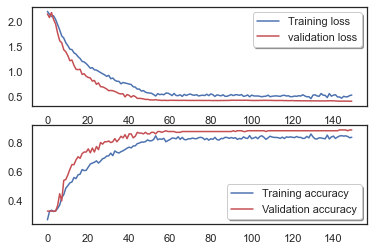

In [19]:
# Dibuja las curvas de perdida y precisión para el entrenamiento y validación
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

El codigo es para dibujar las curvas de perdida y entrenamiento para entrenamiento y validación. Como se asignó epochs = 2 en este notebook. Para un modelo con 30 epocas, el cual puede correr en varias horas (2h30 de acuerdo al articulo original)

El modelo alcanza una precisión de 99% (98,7%) en el dataset de validación luego de 2 épocas. La validación  de precisión es mayor que la precisión de entrenamiento casi todo el tiempo durante el entrenamiento. Esto significa que el modelo no sobreajusta el conjunto de datos de entrenamiento.

## 4.2 Matriz de confusión

La matriz de confusión puede ser muy útil para ver los errores (drawbacks) del modelo.

Se dibjua una matriz de confusión de los resultados de la validación.

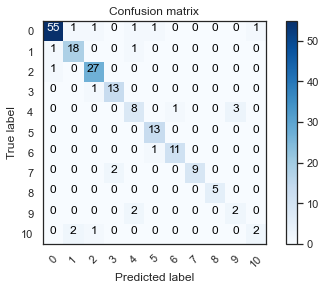

In [20]:
# Observe la matriz de confusion 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predice los valores del dataset de validación
Y_pred = model.predict(X_val)
# Convierte las clases de predicciones a un único vector (one hot vectors)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convierte las observaciones de validación a un único vector (one hot vectors)
Y_true = np.argmax(Y_val,axis = 1) 
# calcula la matriz de confusion
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# dibuja la matriz de confusión
plot_confusion_matrix(confusion_mtx, classes = range(11)) 

Aquí se puede observar que la CNN funciona bien en todos los dígitos con algunos pocos errores considerando el tamañó del dataset de validación (4200 imágenes).

Sin embargo, parece que la CNN tiene algunos probelmas con 4 dígitos, que son mal clasificados como 9. A veces es dificil identificar la diferencia entre 4 y 9 cuando las curvas son suaves.

Podemos investigar estos errores.

Queremos ver los errores más importantes. Para este proposito, se necesita ver la diferencia entre las probalidades del valor real y el valor predicho en los resultados.

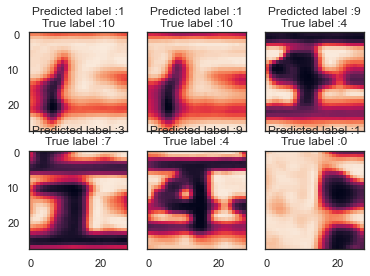

In [21]:
# Mostrar algunos errores

# Los errores son la diferencia entre el valor predicho y las etiquetas verdaderas.
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilidades de los numeros incorrectamente predichos. 
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Probabilidades predichas de los valores reales en el conjunto de datos de error
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Diferencia entre la probabilidad de la etiqueta predicha y la verdadera etiqueta
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Lista ordenada de los errores de probabilidad delta
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Los 6 errores más importantes
most_important_errors = sorted_dela_errors[-6:]

# Mostrar los 6 errores más importantes
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

Los errores más importantes son también los mas intrigantes (interesantes)

Para estos seis casos, el modelo no es ridículo. Algunos de estos errores puede ser también hechos por humanos, especialmente para el 9 que es muy parecido al 4. El último 9 también es muy confuso, parece un 0.
For those six case, the model is not ridiculous. Some of these errors can also be made by humans, especially for one the 9 that is very close to a 4. The last 9 is also very misleading, it seems for me that is a 0.